In [1]:
import os
import re
import json
import matplotlib.pyplot as plt
import pandas as pd
import glob
from sklearn.metrics import auc

In [2]:
%matplotlib inline

In [3]:
NAME_REGEX = r"((checkpoint|events|args).*)|report-dev-m(?P<d>[^-]*)-(?P<s>[0-9]*)-real(?P<t>(train)?)\.jsonl$"

In [4]:
def table_of_accuracies(label):
    print(label)
    [logdir] = glob.glob("../logdirs-overfit/{},*".format(label))
    data = []
    for f in os.listdir(logdir):
        if not f.endswith(".jsonl"): continue
        m = re.match(NAME_REGEX, f)
        assert m, "{} not a valid name".format(f)
        if m.group("d") is None:
            print(m)
            1/0
            continue
            
        checkpoint = int(m.group("s"))
        
        with open(os.path.join(logdir, f)) as fp:
            try:
                stats = json.loads(next(fp))
            except StopIteration:
                stats = {}
        if not stats.get('done'):
            print(os.path.join(logdir, f))
            print(stats)
            continue
        
        auc_val = auc(stats['fpr'], stats['tpr'])
        
        [[tn, fp], [fn, tp]] = stats['confusion']
                
        negative_acc = tn / (tn + fp)
        positive_acc = tp / (tp + fn)
        
        bal_acc = (negative_acc + positive_acc) / 2
        
        data.append([label, checkpoint, stats['accuracy'], negative_acc, positive_acc, bal_acc, auc_val, m.group("t") + m.group("d")])
    df = pd.DataFrame(
        data, columns=['Model', 'Step', 'Accuracy', 'Accuracy Among Negative', 'Accuracy Among Positive', 'Balanced Accuracy', 'AUC', 'DataSource']
    )
    return df


In [5]:
model_labels = """
overfit-vanilla-slow-split
overfit-aggregate-standard-slow-split
overfit-aggregate-with-io-slow-split
overfit-vanilla-all-beams-balanced-load-debugger
overfit-vanilla-all-beams-balanced
overfit-awoi-all-beams-balanced-load-debugger
overfit-awio-all-beams-balanced
""".strip().split("\n")
model_labels = [x for x in model_labels if x[0] != '#']

In [6]:
accuracies = [table_of_accuracies(x) for x in model_labels]
accuracies = pd.concat(accuracies)

overfit-vanilla-slow-split
overfit-aggregate-standard-slow-split
overfit-aggregate-with-io-slow-split
overfit-vanilla-all-beams-balanced-load-debugger
overfit-vanilla-all-beams-balanced
overfit-awoi-all-beams-balanced-load-debugger
overfit-awio-all-beams-balanced


In [7]:
def get_accuracies(model, data_source, data_label=None, metric='Accuracy'):
    selected_rows = (accuracies.Model == model) & (accuracies.DataSource == data_source)
    if data_label is not None:
        selected_rows &= accuracies.DataLabel == data_label
    return accuracies[selected_rows].pivot(index='Step', columns='DataSource', values=metric)
def plot_combined_accuracy(table, label, metric='Accuracy'):
    if not table.index.size:
        return
    cols = sorted(table.columns)
    result = sum(table[col] for col in cols) * 100 / len(cols)
    plt.plot(result, ".-", label=label)
    plt.xlabel("Step")
    plt.ylabel("{} [%]".format(metric))
    plt.legend()

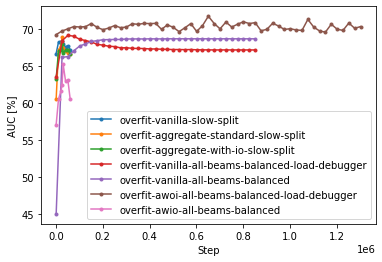

In [8]:
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'trainnearai32', metric='AUC'), model, 'AUC')

In [9]:
accuracies.sort_values('AUC').iloc[-1]

Model                      overfit-aggregate-standard-slow-split
Step                                                       54000
Accuracy                                                0.610219
Accuracy Among Negative                                 0.716981
Accuracy Among Positive                                 0.604413
Balanced Accuracy                                       0.660697
AUC                                                     0.737016
DataSource                                              nearai32
Name: 42, dtype: object

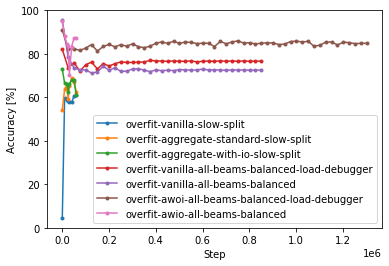

In [10]:
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'trainnearai32', metric='Accuracy'), model, 'Accuracy')

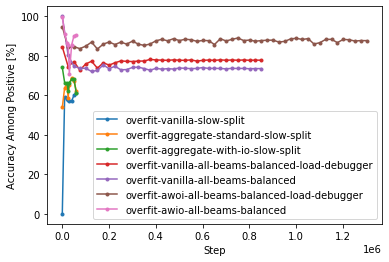

In [11]:
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'trainnearai32', metric='Accuracy Among Positive'), model, 'Accuracy Among Positive')

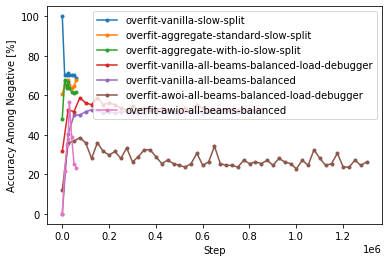

In [12]:
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'trainnearai32', metric='Accuracy Among Negative'), model, 'Accuracy Among Negative')

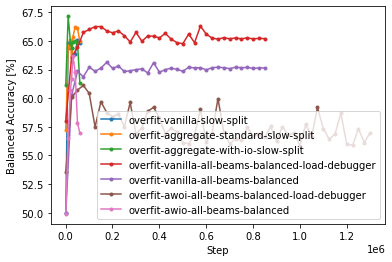

In [13]:
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'trainnearai32', metric='Balanced Accuracy'), model, 'Balanced Accuracy')

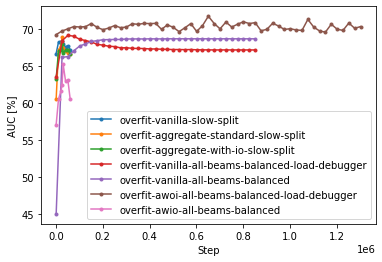

In [14]:
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'trainnearai32', metric='AUC'), model, 'AUC')